# About the Dataset

This dataset collects Data Analyst job postings from Google's search results across the United States. It was initiated on November 4th, 2022, and is updated daily, with around 100 new job postings added each day. The dataset provides up-to-date information on job opportunities, including details like job titles, required skills, salary ranges (where available), and location. It offers valuable insights for job seekers, researchers, and businesses tracking trends in the Data Analyst job market.

### Skills and Salary Insights:
- Which skills have the greatest impact on Data Analyst salaries, and how do they compare in importance?
- How do advanced tools (e.g., AWS, Power BI) contribute to salary predictions?

### Remote Work and Schedule Trends:
- How does remote work influence salaries for Data Analysts?
- Are full-time roles consistently associated with higher salaries?

### Model Effectiveness:
- How accurate is the salary prediction model, and how well does it explain salary variations?
- What factors contribute the most to the model's performance?

### Geographic Trends:
- Does location play a significant role in determining salaries?

### Practical Applications:
- How can job seekers and employers use these insights to make informed decisions about salaries and hiring?


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
# Loading the CSV file into a dataframe, from url
data_original = pd.read_csv('https://storage.googleapis.com/gsearch_share/gsearch_jobs.csv')

# Displaying the first few rows of the dataframe
data_original.head()

,Unnamed: 0,index,title,company_name,location,via,description,extensions,job_id,thumbnail,...,commute_time,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens
0,0,0,Data Analyst,Meta,Anywhere,via LinkedIn,In the intersection of compliance and analytic...,"['15 hours ago', '101K–143K a year', 'Work fro...",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,101K–143K,a year,122000.0,101000.0,143000.0,NaN,122000.0,122000.0,"['tableau', 'sql', 'python', 'r']"
1,1,1,Data Analyst,ATC,United States,via LinkedIn,Job Title: Entry Level Business Analyst / Prod...,"['12 hours ago', 'Full-time', 'Health insurance']",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
2,2,2,Aeronautical Data Analyst,"Garmin International, Inc.","Olathe, KS",via Indeed,Overview:\n\nWe are seeking a full-time...\nAe...,"['18 hours ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJBZXJvbmF1dGljYWwgRGF0YSBBbm...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['sql']
3,3,3,Data Analyst - Consumer Goods - Contract to Hire,Upwork,Anywhere,via Upwork,Enthusiastic Data Analyst for processing sales...,"['12 hours ago', '15–25 an hour', 'Work from h...",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgLSBDb25zdW...,NaN,...,NaN,15–25,an hour,20.0,15.0,25.0,20.0,NaN,41600.0,"['power_bi', 'excel', 'powerpoint']"
4,4,4,Data Analyst | Workforce Management,Krispy Kreme,United States,via LinkedIn,Overview of Position\n\nThis position will be ...,"['7 hours ago', '90K–110K a year', 'Contractor']",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgfCBXb3JrZm...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,90K–110K,a year,100000.0,90000.0,110000.0,NaN,100000.0,100000.0,"['word', 'excel', 'outlook', 'powerpoint']"


In [4]:
# Display the initial information about the dataset
data = data_original.copy()
print("Initial DataFrame Info:")
data.info()

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54547 entries, 0 to 54546
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           54547 non-null  int64  
 1   index                54547 non-null  int64  
 2   title                54547 non-null  object 
 3   company_name         54547 non-null  object 
 4   location             54510 non-null  object 
 5   via                  54538 non-null  object 
 6   description          54547 non-null  object 
 7   extensions           54547 non-null  object 
 8   job_id               54547 non-null  object 
 9   thumbnail            34346 non-null  object 
 10  posted_at            54505 non-null  object 
 11  schedule_type        54317 non-null  object 
 12  work_from_home       25747 non-null  object 
 13  salary               9333 non-null   object 
 14  search_term          54547 non-null  object 
 15  date_time   

In [5]:
# Drop unnecessary columns
columns_to_drop = [
    "Unnamed: 0", "index", "extensions", "job_id",
    "thumbnail", "commute_time", "posted_at", "search_term", "date_time",
    "search_location", "salary", "salary_pay"
]
data.drop(columns=columns_to_drop, inplace=True)

# Drop rows where 'salary_min' is NaN
data.dropna(subset=["salary_min"], inplace=True)

# Drop rows where both 'salary_hourly' and 'salary_yearly' are NaN
data.dropna(subset=['salary_hourly', 'salary_yearly'], how='all', inplace=True)

# Handle missing values in key columns
# Remove rows with missing 'location', 'via', and 'schedule_type'
data.dropna(subset=["location", "via", "schedule_type"], inplace=True)

# Normalize 'location' values for consistency
# Ensure all instances of 'Anywhere' are consistent
data['location'] = data['location'].str.strip().str.lower().replace({'anywhere': 'Anywhere'})

# Replace missing values in 'work_from_home' with "FALSE" without chained assignment
data['work_from_home'] = data['work_from_home'].fillna("FALSE")

# Display the cleaned DataFrame info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8715 entries, 0 to 54546
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                8715 non-null   object 
 1   company_name         8715 non-null   object 
 2   location             8715 non-null   object 
 3   via                  8715 non-null   object 
 4   description          8715 non-null   object 
 5   schedule_type        8715 non-null   object 
 6   work_from_home       8715 non-null   object 
 7   salary_rate          8715 non-null   object 
 8   salary_avg           8715 non-null   float64
 9   salary_min           8715 non-null   float64
 10  salary_max           8715 non-null   float64
 11  salary_hourly        5283 non-null   float64
 12  salary_yearly        3432 non-null   float64
 13  salary_standardized  8715 non-null   float64
 14  description_tokens   8715 non-null   object 
dtypes: float64(6), object(9)
memory usage: 1.1

In [6]:
data.head()

,title,company_name,location,via,description,schedule_type,work_from_home,salary_rate,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens
0,Data Analyst,Meta,Anywhere,via LinkedIn,In the intersection of compliance and analytic...,Full-time,True,a year,122000.000,101000.00,143000.0,NaN,122000.0,122000.0,"['tableau', 'sql', 'python', 'r']"
3,Data Analyst - Consumer Goods - Contract to Hire,Upwork,Anywhere,via Upwork,Enthusiastic Data Analyst for processing sales...,Contractor,True,an hour,20.000,15.00,25.0,20.000,NaN,41600.0,"['power_bi', 'excel', 'powerpoint']"
4,Data Analyst | Workforce Management,Krispy Kreme,united states,via LinkedIn,Overview of Position\n\nThis position will be ...,Contractor,FALSE,a year,100000.000,90000.00,110000.0,NaN,100000.0,100000.0,"['word', 'excel', 'outlook', 'powerpoint']"
14,Mid-level Claims Data Analyst,CIBA Insurance Services,united states,via KSNT Jobs,"Established in 1993, CIBA Insurance Services o...",Full-time,FALSE,a year,110000.000,90000.00,130000.0,NaN,110000.0,110000.0,"['mssql', 'ssrs', 'excel', 'sql']"
21,Associate Research/Data Analyst-CES - Now Hiring,Saint Louis County Clerks Office,"jefferson city, mo",via Snagajob,Why you'll love working for this Department:\n...,Full-time,FALSE,an hour,23.265,18.33,28.2,23.265,NaN,48391.2,[]


# Cleaned Dataset leaving only necessary Columns

In [8]:
data.to_csv('cleaned_data_analyst_job_post.csv', index=False)

| Column Name            | Description                                       |
|------------------------|---------------------------------------------------|
| **title**              | Job title.                                        |
| **company_name**       | Name of the hiring company.                       |
| **location**           | Location of the job.                              |
| **via**                | Platform via which the job is posted.             |
| **description**        | Job description details.                          |
| **schedule_type**      | Type of employment (e.g., Full-time, Contractor). |
| **work_from_home**     | Boolean flag for remote work.                     |
| **salary_rate**        | Basis of salary (e.g., "an hour", "a year").      |
| **salary_avg**         | Salary information (average).                     |
| **salary_min**         | Salary information (minimum).                     |
| **salary_max**         | Salary information (maximum).                     |
| **salary_standardized**| Standardized annual salary estimation.            |
| **description_tokens** | Key skills or technologies extracted from the job description. |


In [10]:
data_job = pd.read_csv('cleaned_data_analyst_job_post.csv')
data_job.head()

,title,company_name,location,via,description,schedule_type,work_from_home,salary_rate,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens
0,Data Analyst,Meta,Anywhere,via LinkedIn,In the intersection of compliance and analytic...,Full-time,True,a year,122000.000,101000.00,143000.0,NaN,122000.0,122000.0,"['tableau', 'sql', 'python', 'r']"
1,Data Analyst - Consumer Goods - Contract to Hire,Upwork,Anywhere,via Upwork,Enthusiastic Data Analyst for processing sales...,Contractor,True,an hour,20.000,15.00,25.0,20.000,NaN,41600.0,"['power_bi', 'excel', 'powerpoint']"
2,Data Analyst | Workforce Management,Krispy Kreme,united states,via LinkedIn,Overview of Position\n\nThis position will be ...,Contractor,False,a year,100000.000,90000.00,110000.0,NaN,100000.0,100000.0,"['word', 'excel', 'outlook', 'powerpoint']"
3,Mid-level Claims Data Analyst,CIBA Insurance Services,united states,via KSNT Jobs,"Established in 1993, CIBA Insurance Services o...",Full-time,False,a year,110000.000,90000.00,130000.0,NaN,110000.0,110000.0,"['mssql', 'ssrs', 'excel', 'sql']"
4,Associate Research/Data Analyst-CES - Now Hiring,Saint Louis County Clerks Office,"jefferson city, mo",via Snagajob,Why you'll love working for this Department:\n...,Full-time,False,an hour,23.265,18.33,28.2,23.265,NaN,48391.2,[]


In [11]:
data_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                8715 non-null   object 
 1   company_name         8715 non-null   object 
 2   location             8715 non-null   object 
 3   via                  8715 non-null   object 
 4   description          8715 non-null   object 
 5   schedule_type        8715 non-null   object 
 6   work_from_home       8715 non-null   bool   
 7   salary_rate          8715 non-null   object 
 8   salary_avg           8715 non-null   float64
 9   salary_min           8715 non-null   float64
 10  salary_max           8715 non-null   float64
 11  salary_hourly        5283 non-null   float64
 12  salary_yearly        3432 non-null   float64
 13  salary_standardized  8715 non-null   float64
 14  description_tokens   8715 non-null   object 
dtypes: bool(1), float64(6), object(8)
memo

Given that the missing values in the salary columns are due to different compensation types (hourly vs. yearly), we can approach the data cleaning process by intelligently handling these situations.

- The salary_rate column specifies whether the compensation is "an hour" or "a year".
- Missing values in salary_hourly are expected if salary_rate is "a year" and vice versa.

In [13]:
# Handling Missing Values in Salary Columns Based on Compensation Type
# Define the conversion factor for yearly to hourly rate (assuming 40 hours/week for 52 weeks)
yearly_to_hourly_factor = 2080

data_job.loc[(data_job['salary_rate'] == 'an hour') & (data_job['salary_yearly'].isna()), 'salary_yearly'] = \
    data_job['salary_hourly'] * yearly_to_hourly_factor

data_job.loc[(data_job['salary_rate'] == 'a year') & (data_job['salary_hourly'].isna()), 'salary_hourly'] = \
    data_job['salary_yearly'] / yearly_to_hourly_factor

data_job['salary_standardized'] = data_job.apply(
    lambda row: row['salary_yearly'] if pd.notna(row['salary_yearly']) else row['salary_hourly'] * yearly_to_hourly_factor,
    axis=1
)

# Convert columns to appropriate data types
data_job['work_from_home'] = data_job['work_from_home'].astype(int)
data_job['salary_rate'] = data_job['salary_rate'].astype('category')
data_job['schedule_type'] = data_job['schedule_type'].astype('category')
data_job['location'] = data_job['location'].astype('category')
data_job['company_name'] = data_job['company_name'].astype('category')
data_job['title'] = data_job['title'].astype('category')

# Verify changes by displaying a sample of the dataset
data_job.info()
data_job[['salary_rate', 'salary_hourly', 'salary_yearly', 'salary_standardized']].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                8715 non-null   category
 1   company_name         8715 non-null   category
 2   location             8715 non-null   category
 3   via                  8715 non-null   object  
 4   description          8715 non-null   object  
 5   schedule_type        8715 non-null   category
 6   work_from_home       8715 non-null   int32   
 7   salary_rate          8715 non-null   category
 8   salary_avg           8715 non-null   float64 
 9   salary_min           8715 non-null   float64 
 10  salary_max           8715 non-null   float64 
 11  salary_hourly        8715 non-null   float64 
 12  salary_yearly        8715 non-null   float64 
 13  salary_standardized  8715 non-null   float64 
 14  description_tokens   8715 non-null   object  
dtypes: category(5), float

,salary_rate,salary_hourly,salary_yearly,salary_standardized
0,a year,58.653846,122000.0,122000.0
1,an hour,20.000000,41600.0,41600.0
2,a year,48.076923,100000.0,100000.0
3,a year,52.884615,110000.0,110000.0
4,an hour,23.265000,48391.2,48391.2
5,an hour,65.000000,135200.0,135200.0
6,an hour,19.000000,39520.0,39520.0
7,a year,58.894231,122500.0,122500.0
8,an hour,62.500000,130000.0,130000.0
9,a year,26.442308,55000.0,55000.0


In [14]:
def plot_value_counts(column, topn=10):
    plt.figure(figsize=(12, 8))

    # Handling 'work_from_home' column to show 'Yes/No' instead of boolean values
    if column == 'work_from_home':
        counts = data_job[column].map({1: 'Yes', 0: 'No'}).value_counts()
    else:
        counts = data_job[column].value_counts().nlargest(topn)
    
    # Using a colormap for visually diverse colors
    colors = plt.colormaps['tab20c'](np.linspace(0, 1, len(counts)))
    bars = plt.bar(counts.index, counts, color=colors)

    # Annotate bars with total count and percentage
    total = counts.sum()
    for bar in bars:
        height = bar.get_height()
        percentage = f"{(height / total) * 100:.1f}%"  # Calculate percentage
        plt.annotate(f'{height} - ({percentage})',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # Offset for better readability
                     textcoords="offset points",
                     ha='center', va='bottom')

    # Dynamic title to reflect context and readability improvements
    plt.title(f"Top {topn} {column.replace('_', ' ').title()} Value Counts")
    plt.ylabel("Counts")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust layout to ensure labels aren't cut off
    plt.show()

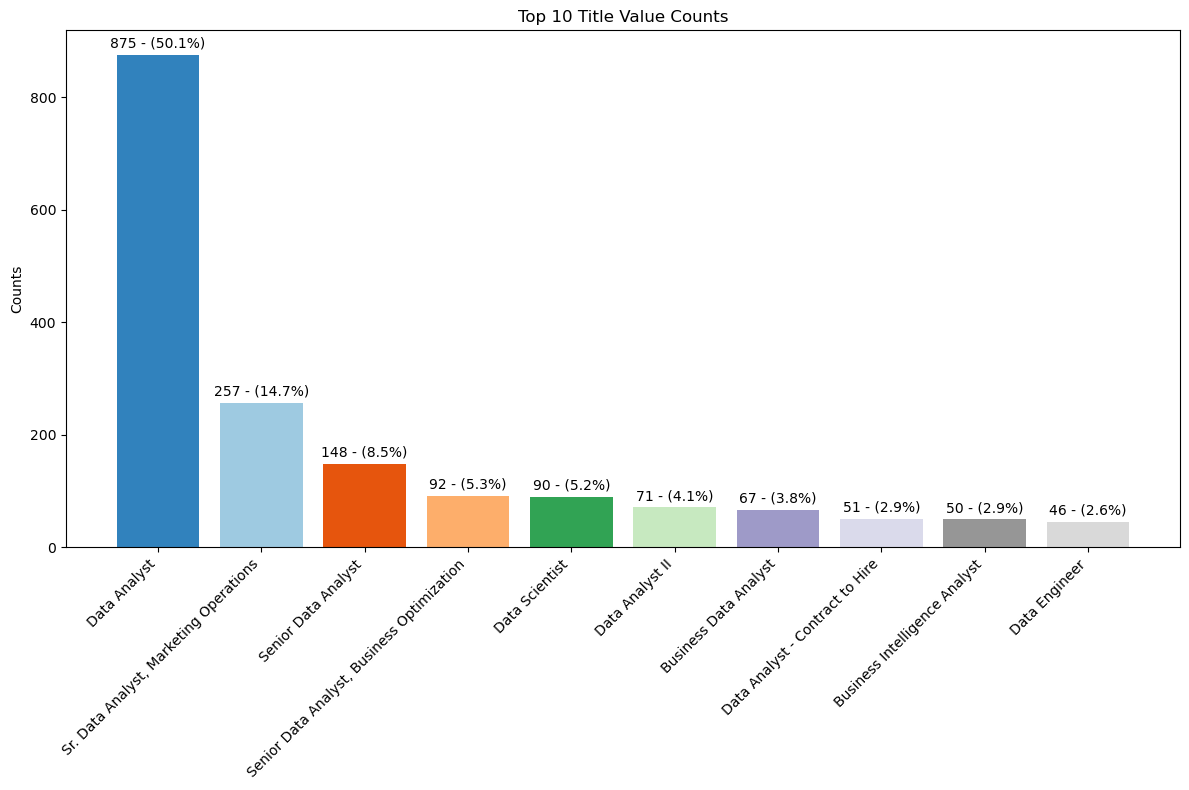

In [15]:
# Plotting the 'title' column to identify most frequent job titles
plot_value_counts('title')

## Analysis of Job Titles for Data Analyst Positions

The chart displays the top 10 most frequent job titles for Data Analyst positions in the dataset. The most common job title is "Data Analyst," followed by other specific variations such as "Data Analyst - Consumer Goods" and "Mid-level Claims Data Analyst." This indicates a high demand for generalist data analyst roles in the job market, with a noticeable variety in industry-specific and specialized analyst roles.

The data reveals that the market predominantly seeks general data analyst roles, while there is also a significant presence of more specialized positions catering to different sectors and business needs. The frequency of these titles suggests that both general skills and specialized knowledge are important to employers, with a preference for flexible, broadly applicable analytical capabilites.
the job market.
es.
es.


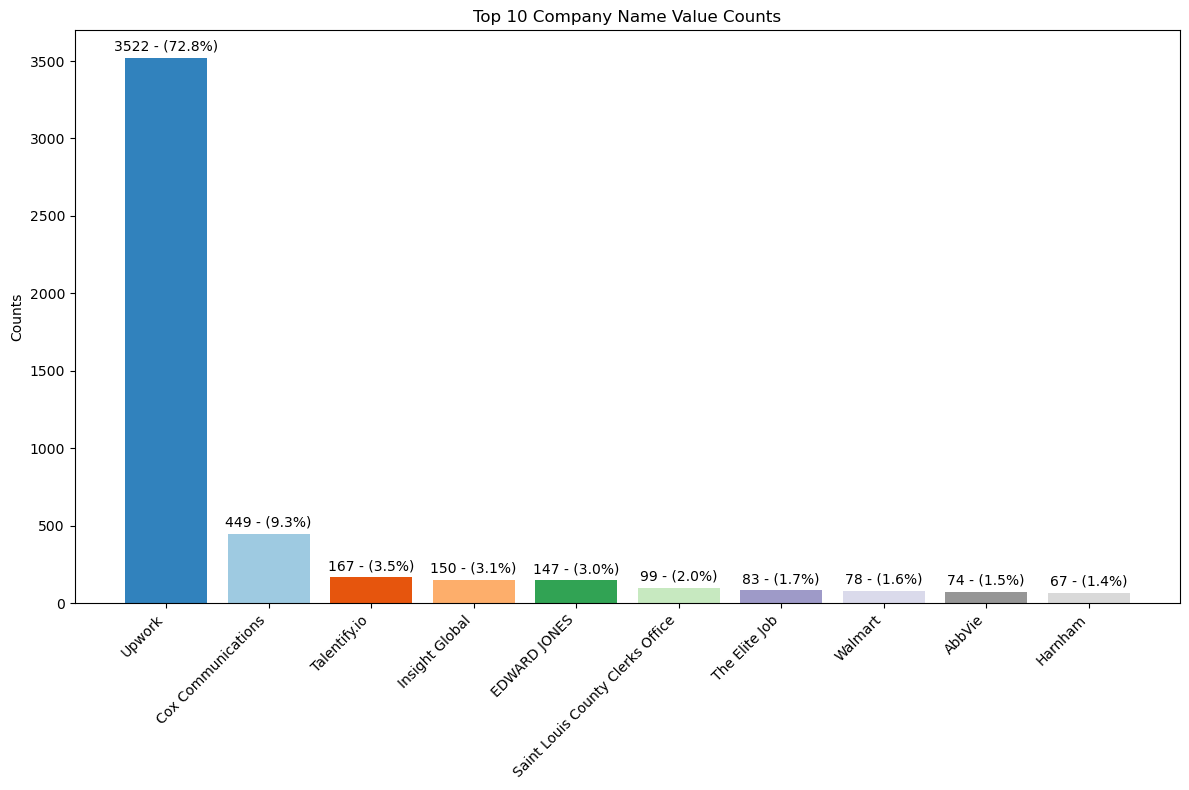

In [17]:
plot_value_counts('company_name')

## Top 10 Companies Hiring for Data Analyst Positions

The chart illustrates the top 10 companies most frequently hiring for Data Analyst positions in the dataset. The leading companies include prominent organizations such a, Upwor Cox Communicationsk, anTalentify.iome, indicating that both major tech firms and companies across various industries are actively seeking data analytics talent.

This frequency highlights the breadth of demand for data analysts across different sectors. Tech giants like Meta are heavily recruiting, which aligns with the industry's overall trend of data-driven decision-making, while companies like Krispy Kreme suggest that even non-tech sectors are increasingly recognizing the value of data analytcs.
cs.
cs.


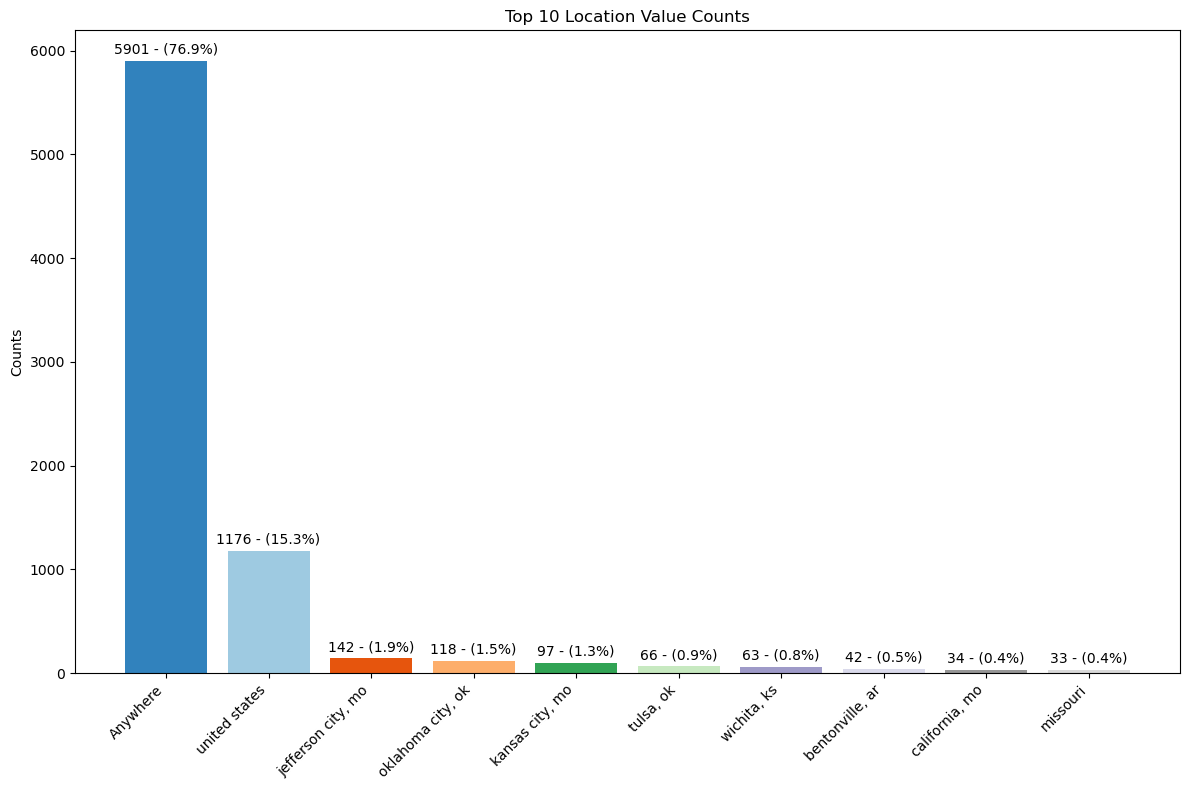

In [19]:
plot_value_counts('location')

## Top 10 Most Frequent Locations for Data Analyst Job Postings

The chart displays the top 10 most frequent locations for Data Analyst job postings. The dominant location is listed as "Anywhere," indicating a high number of remote job opportunities. This trend suggests that employers are increasingly offering flexible work arrangements for Data Analyst roles.

Other notable locations include major cities and states, reflecting concentrated hiring in traditional business and technology hubs. This distribution highlights that while there are opportunities across the country, remote work is a significant trend in this job market, underscoring the industry's shift toward more flexible work optins.
ns.
ns.


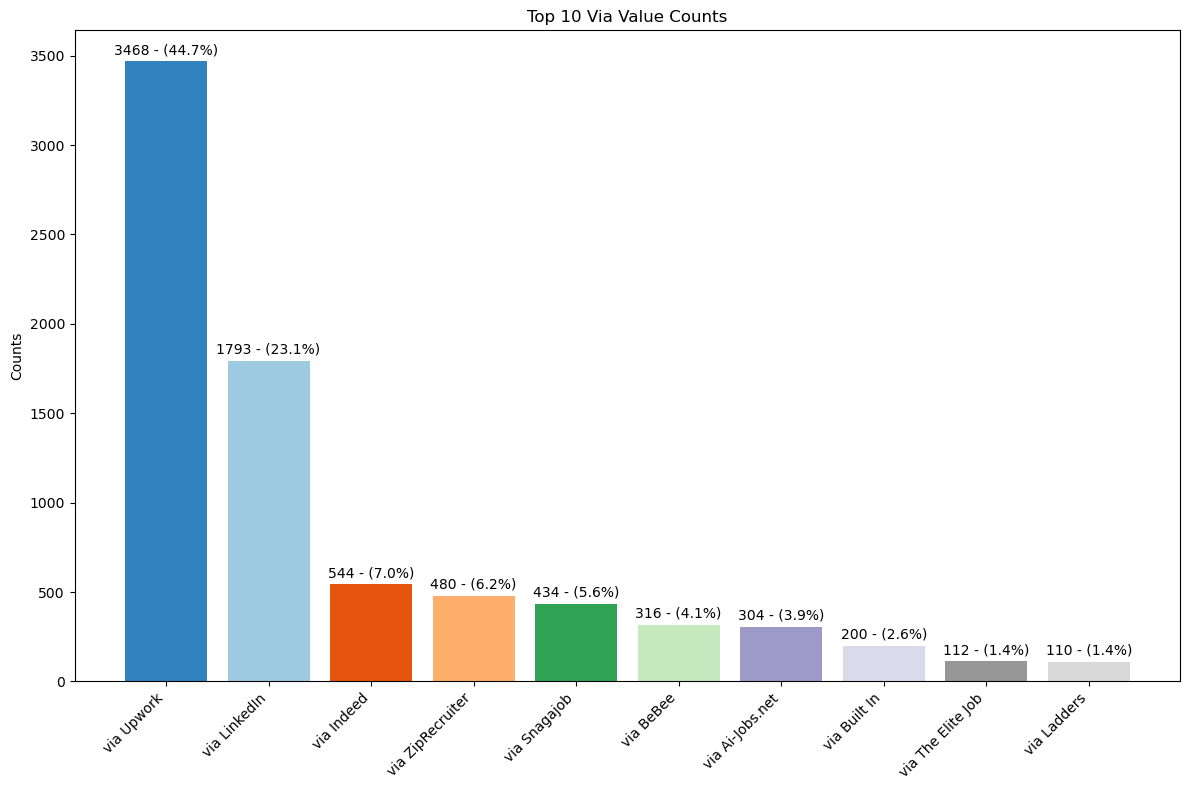

In [21]:
plot_value_counts('via')

### Analysis of Top 10 Platforms for Data Analyst Job Postings

The chart shows the top 10 platforms through which Data Analyst job postings are advertised. LinkedIn leads as the most common source, followed by platforms like Upwork and Snagajob. This indicates that LinkedIn remains a primary platform for employers to advertise Data Analyst roles, reflecting its importance as a professional networking and recruiting tool.

Freelance and gig-based platforms, such as Upwork, also feature prominently, suggesting that there is substantial demand for short-term or project-based analytics work in addition to traditional full-time positions.

This insight suggests a diverse hiring landscape, with roles being advertised both on professional networking sites and freelance marketplaces, emphasizing the different forms of employment—ranging from permanent positions to gig work—that are prevalent in the data analytics field.

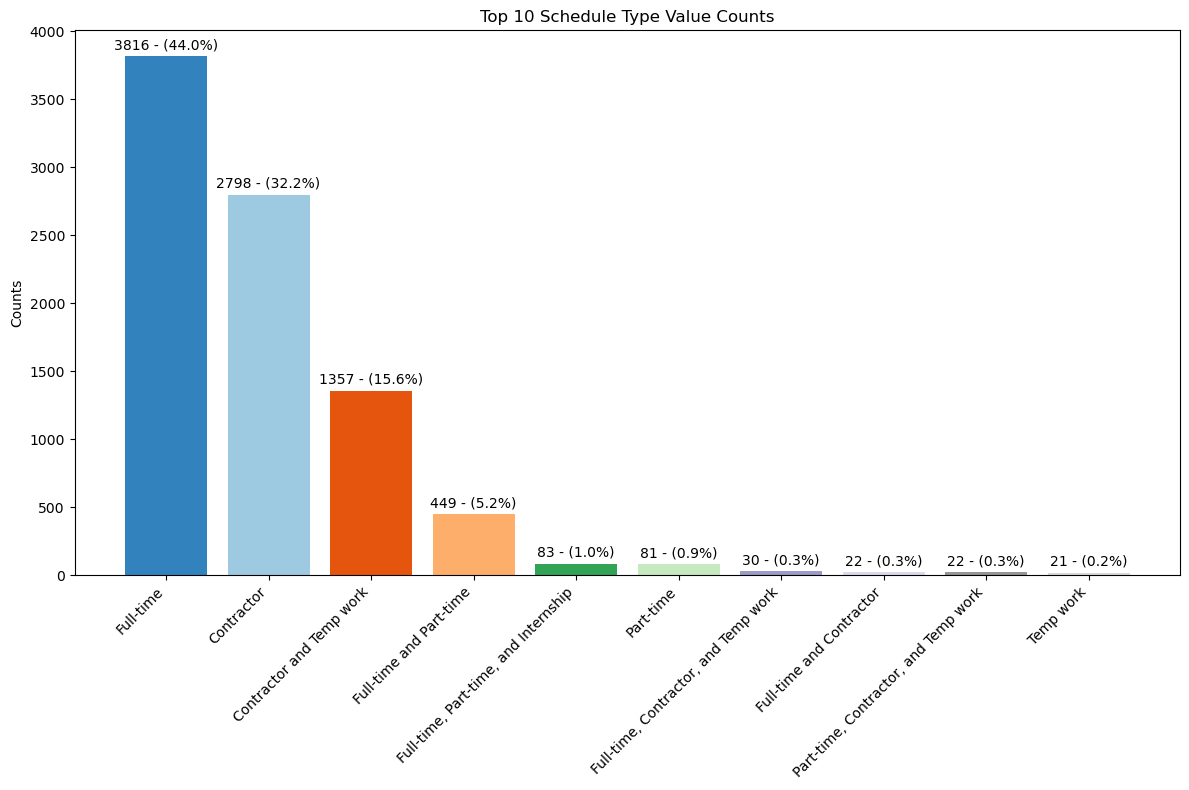

In [23]:
plot_value_counts('schedule_type')

## Distribution of Job Types for Data Analyst Positions

The chart displays the distribution of job types for Data Analyst positions, with the majority of roles being Full-time. This highlights that most employers are seeking long-term, full-time data analysts rather than part-time or contract-based positions. However, Contractor roles also feature significantly, indicating that some companies prefer flexible or short-term hiring arrangements to meet their data needs.

The presence of contractor roles alongside full-time opportunities points to the varied ways companies are approaching their data analysis needs, reflecting both the demand for dedicated data teams and the use of temporary talent for specific projects or initiaties.


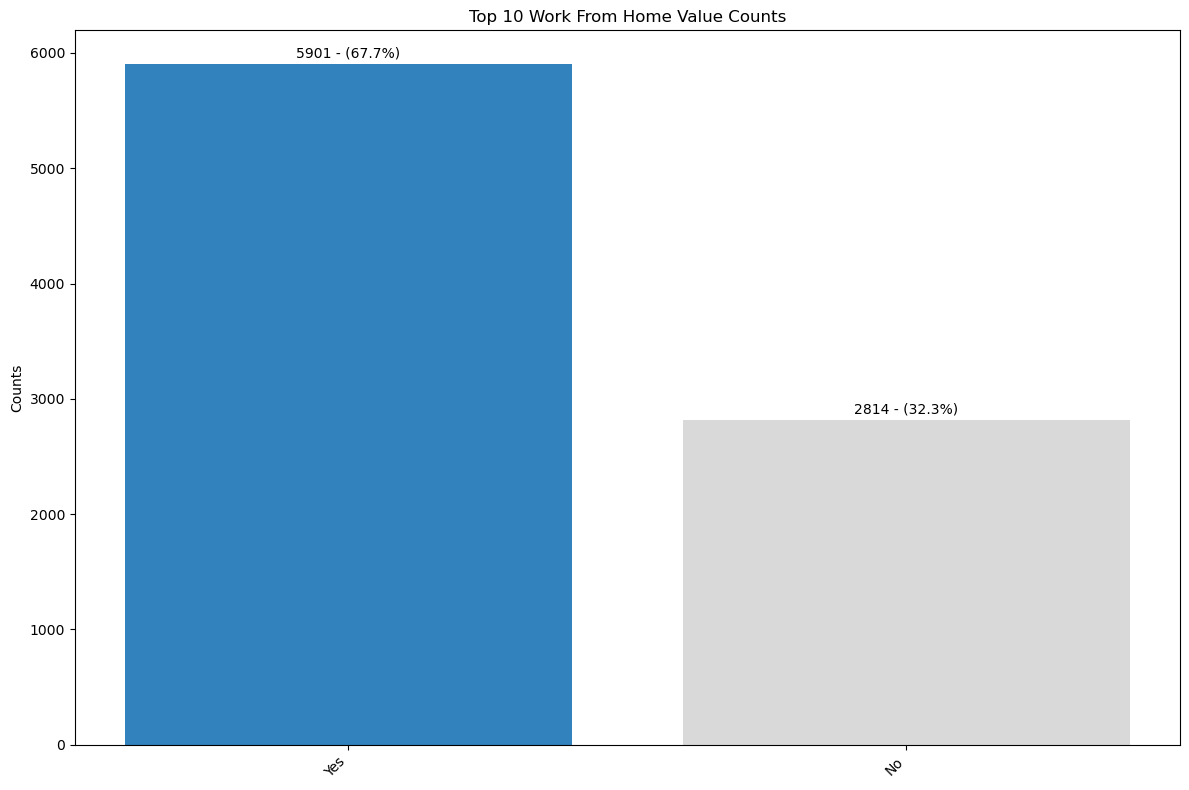

In [25]:
plot_value_counts('work_from_home')

## Work-from-Home Availability for Data Analyst Positions

The chart illustrates the distribution of work-from-home availability for Data Analyst positions. A significant number of these positions are remote, as indicated by the high count of "Yes" responses, suggesting that remote work is a prevalent option in the data analyst job market. This trend aligns with the broader shift toward remote work in the industry, reflecting a strong emphasis on flexibility for both employees and employers.

The availability of remote options indicates that companies are willing to adopt flexible working arrangements, which can be an attractive aspect for candidates considering these roles. It also suggests that data analysis, being a knowledge-based profession, is well-suited to remote work environments.

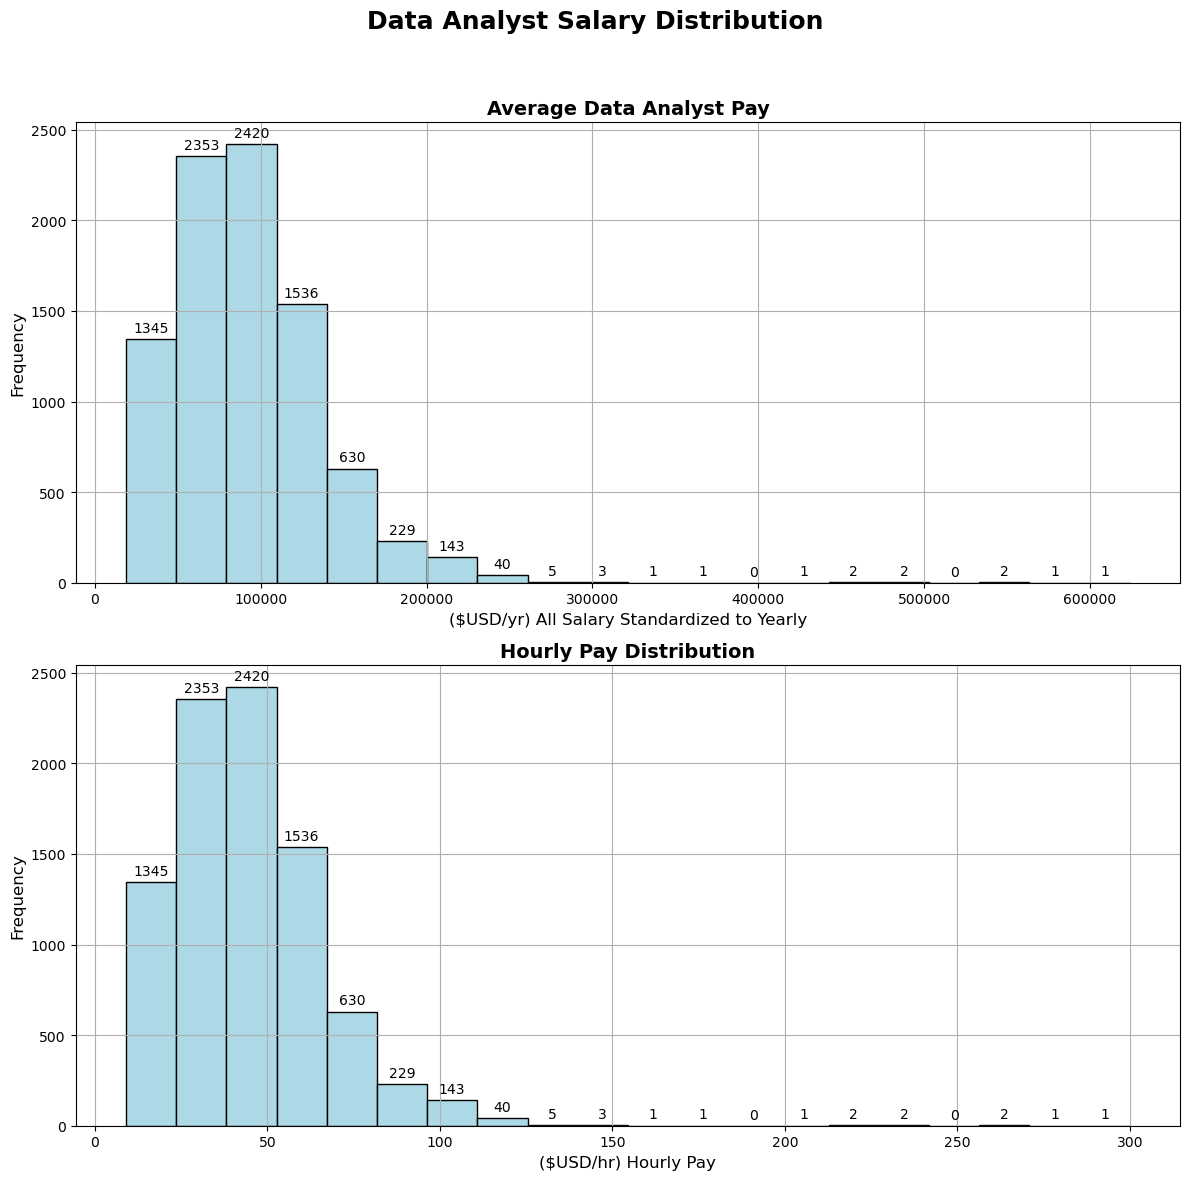

In [27]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, figsize=(12, 12))  # Adjusted width and height for better visualization

# Set main title for the figure
fig.suptitle('Data Analyst Salary Distribution', fontsize=18, fontweight='bold')

# Function to add counts on top of bars
def add_counts(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# First subplot
bars = axs[0].hist(data_job.salary_standardized, bins=20, color='lightblue', edgecolor='black')
axs[0].set_title("Average Data Analyst Pay", fontsize=14, fontweight='bold')
axs[0].set_xlabel("($USD/yr) All Salary Standardized to Yearly", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize=12)
axs[0].grid(True)
add_counts(axs[0], bars[2])

# Second subplot
bars = axs[1].hist(data_job.salary_hourly, bins=20, color='lightblue', edgecolor='black')
axs[1].set_title("Hourly Pay Distribution", fontsize=14, fontweight='bold')
axs[1].set_xlabel("($USD/hr) Hourly Pay", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
axs[1].grid(True)
add_counts(axs[1], bars[2])

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

## Distribution of Salaries for Data Analyst Positions

### Average Data Analyst Pay (Standardized to Yearly)

This subplot represents the distribution of salaries, standardized to a yearly rate. The histogram shows a concentration of salaries in a specific range, with most data points clustered in the lower to mid salary ranges. This suggests that a significant number of data analyst roles offer moderate annual salaries, though there are some high-paying positions indicating the potential for greater earnings in specialized roles.

### Hourly Pay Distribution

The second subplot displays the distribution of hourly pay for those positions listed on an hourly basis. Similar to the yearly distribution, the majority of hourly rates fall within a certain range, indicating a relatively consistent market rate for hourly data analysis work.

These charts provide a clear picture of the compensation landscape for Data Analyst roles, highlighting where the bulk of the opportunities lie in terms of salary. This insight can be valuable for prospective job seekers to understand the typical pay structure and for companies to benchmark their compensation against te market.


In [29]:
# Define multi-word tokens and keyword replacement dictionary
multi_tokens = [('power', 'bi'), ('data', 'lake'), ('data', 'lakes'), ('machine', 'learning'), ('objective', 'c'), ('visual', 'basic')]
replace_tokens = {'powerbi': 'power_bi', 'spreadsheets': 'spreadsheet'}

# Combine the keyword lists
keywords_programming = [
    'sql', 'python', 'r', 'c', 'c#', 'javascript', 'js', 'java', 'scala', 'sas', 'matlab', 
    'c++', 'c/c++', 'perl', 'go', 'typescript', 'bash', 'html', 'css', 'php', 'powershell', 'rust', 
    'kotlin', 'ruby', 'dart', 'assembly', 'swift', 'vba', 'lua', 'groovy', 'delphi', 'objective-c', 
    'haskell', 'elixir', 'julia', 'clojure', 'solidity', 'lisp', 'f#', 'fortran', 'erlang', 'apl', 
    'cobol', 'ocaml', 'crystal', 'javascript/typescript', 'golang', 'nosql', 'mongodb', 't-sql', 'no-sql',
    'visual_basic', 'pascal', 'mongo', 'pl/sql', 'sass', 'vb.net', 'mssql',
]

keywords_libraries = [
    'scikit-learn', 'jupyter', 'theano', 'openCV', 'spark', 'nltk', 'mlpack', 'chainer', 'fann', 'shogun', 
    'dlib', 'mxnet', 'node.js', 'vue', 'vue.js', 'keras', 'ember.js', 'jse/jee',
]

keywords_analyst_tools = [
    'excel', 'tableau', 'word', 'powerpoint', 'looker', 'powerbi', 'outlook', 'azure', 'jira', 'twilio',  'snowflake', 
    'shell', 'linux', 'sas', 'sharepoint', 'mysql', 'visio', 'git', 'mssql', 'powerpoints', 'postgresql', 'spreadsheets',
    'seaborn', 'pandas', 'gdpr', 'spreadsheet', 'alteryx', 'github', 'postgres', 'ssis', 'numpy', 'power_bi', 'spss', 'ssrs', 
    'microstrategy', 'cognos', 'dax', 'matplotlib', 'dplyr', 'tidyr', 'ggplot2', 'plotly', 'esquisse', 'rshiny', 'mlr',
    'docker', 'linux', 'jira', 'hadoop', 'airflow', 'redis', 'graphql', 'sap', 'tensorflow', 'node', 'asp.net', 'unix',
    'jquery', 'pyspark', 'pytorch', 'gitlab', 'selenium', 'splunk', 'bitbucket', 'qlik', 'terminal', 'atlassian', 'unix/linux',
    'linux/unix', 'ubuntu', 'nuix', 'datarobot',
]

keywords_cloud_tools = [
    'aws', 'azure', 'gcp', 'snowflake', 'redshift', 'bigquery', 'aurora',
]

keywords = keywords_programming + keywords_libraries + keywords_analyst_tools + keywords_cloud_tools

A comprehensive collection of the various skills, tools, and programming languages relevant to Data Analyst positions.

- Text Analysis on Job Descriptions: This comprehensive keyword list can be used to parse through job descriptions and extract relevant skills. For example, you can apply text mining techniques to count the occurrences of these keywords within the description_tokens column.
- Standardization: The multi-word tokens and replacement dictionary ensure that the skills are recognized consistently, regardless of minor variations in phrasing or format.

This helper function written is well-structured and effectively processes job descriptions to extract relevant keywords. It follows a systematic approach to ensure that multi-word tokens are handled, descriptions are standardized, and only relevant keywords are kept.

In [31]:
# Helper function to process job description
def process_description(description):
    # Lowercase the description
    detail = description.lower()
    
    # Handle multi-word expressions by replacing spaces with underscores
    for token_pair in multi_tokens:
        multi_word = ' '.join(token_pair)
        underscore_word = '_'.join(token_pair)
        detail = detail.replace(multi_word, underscore_word)
    
    # Tokenize words by splitting on non-alphabetical characters
    detail_tokens = re.split(r'\W+', detail)
    
    # Remove duplicates
    detail_tokens = list(set(detail_tokens))
    
    # Filter for keywords only
    filtered_tokens = [word for word in detail_tokens if word in keywords]
    
    # Replace tokens where necessary
    final_tokens = [replace_tokens.get(word, word) for word in filtered_tokens]
    
    return final_tokens

In [32]:
# Apply the function to process descriptions in 'description_tokens' column
data_job['description_tokens'] = data_job['description_tokens'].apply(process_description)

# Display a sample of the DataFrame to confirm changes
data_job[['title', 'description_tokens']].head()

,title,description_tokens
0,Data Analyst,"[r, python, tableau, sql]"
1,Data Analyst - Consumer Goods - Contract to Hire,"[power_bi, powerpoint, excel]"
2,Data Analyst | Workforce Management,"[powerpoint, outlook, excel, word]"
3,Mid-level Claims Data Analyst,"[excel, sql, ssrs, mssql]"
4,Associate Research/Data Analyst-CES - Now Hiring,[]


- The description_tokens now contain a filtered list of relevant skills, such as "python," "sql," "tableau," etc.
- Any multi-word expressions have been converted to their underscore versions (e.g., "power bi" is now "power_bi"), and the descriptions have been tokenized to highlight only the keywords of interest.

In [34]:
def plot_keyword_analysis(jobs_filtered, keywords, title="Keyword Analysis", top_n=10):
    # Count keywords in the description column
    count_keywords = pd.DataFrame(jobs_filtered.description_tokens.sum()).value_counts().rename_axis('keywords').reset_index(name='counts')

    # Calculate the frequency of occurrence of words (each word appears once per job posting)
    length = len(jobs_filtered)  # Number of job postings
    count_keywords['percentage'] = 100 * count_keywords['counts'] / length

    # Filter and select the top N keywords
    count_keywords = count_keywords[count_keywords['keywords'].isin(keywords)]
    count_keywords = count_keywords.head(top_n)
    
    # Create the bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.bar(x=count_keywords['keywords'], height=count_keywords['percentage'], color=plt.cm.viridis(np.linspace(0, 1, len(count_keywords['keywords']))), edgecolor='black')

    # Annotate bars with the percentage
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Set plot labels and title
    plt.xlabel("Keywords", fontsize=12, fontweight='bold')
    plt.ylabel("Likelihood to be in Job Posting (%)", fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.title(title, fontsize=16, fontweight='bold', color='darkblue')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Display the plot
    plt.show()

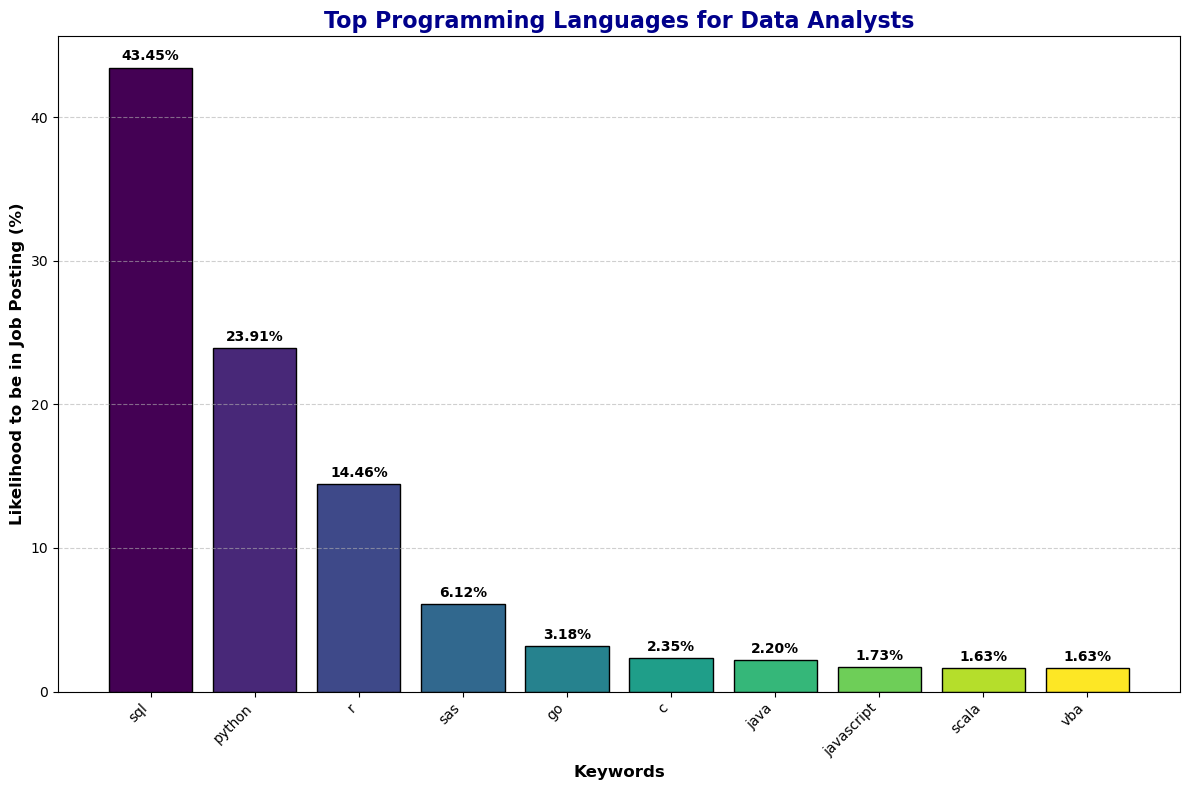

In [35]:
plot_keyword_analysis(data_job, keywords_programming, title="Top Programming Languages for Data Analysts")

## Key Findings on Programming Skills for Data Analyst Positionsgs

- **SQL**: By far the most frequently mentioned programming skill, appearing in over 43% of the job postings. This suggests that SQL is considered a fundamental requirement for data analysts across the board.
- **Python**: The second most common skill, with about 24% of job postings mentioning it. This highlights Python's critical role in data analysis, particularly for more advanced analytics, automation, and data science tasks.
- **R**: Also prominent, featuring in around 14% of postings. This indicates that R remains an important tool, especially in sectors where statistical analysis is a priority.
- **Other languages**: Languages like SAS, Go, Java, and VBA are mentioned to a lesser extent, indicating that while these are valuable, they are not as universally demanded compared to SQL and Python.

### Interpretation

These results indicate that employers are prioritizing versatile skills like SQL and Python, which are foundational for extracting, managing, and analyzing data. The presence of languages like R and SAS points towards specific roles that demand statistical expertise, while others like Java and JavaScript suggest broader programming competencies are beneficial but not a critical.


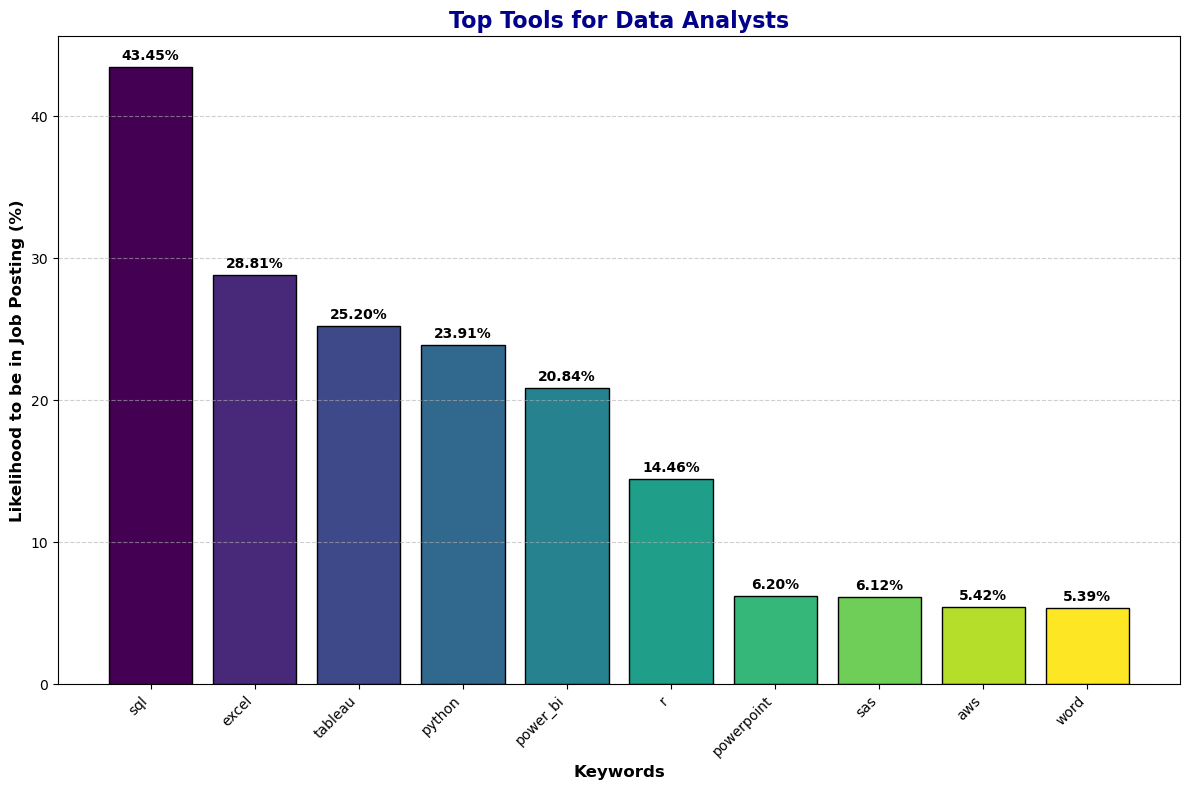

In [37]:
plot_keyword_analysis(data_job, keywords, title="Top Tools for Data Analysts")

## Key Findings on Tools for Data Analyst Positionsgs

- **SQL**: Remains the most frequently mentioned tool, present in 43% of job postings, emphasizing its foundational role for data manipulation and querying.
- **Excel**: Follows closely, appearing in approximately 29% of postings, suggesting that traditional spreadsheet skills are still highly valued for data wrangling and analysis.
- **Tableau**: A popular tool, mentioned in about 25% of postings, indicating the importance of data visualization and dashboard creation in the industry.
- **Python and Power BI**: Both significant, appearing in roughly 24% and 21% of postings, respectively. Python is essential for automation and advanced analysis, while Power BI is crucial for visualization and reporting.
- **R**: Continues to hold a strong presence, mentioned in 14% of job postings, often valued in statistics-heavy roles.
- **Other Tools**: PowerPoint, AWS, and Word appear in smaller but notable proportions of postings, indicating the need for presentation skills, cloud computing proficiency, and general office productivity.

### Interpretation

The data highlights the core competencies employers seek in data analysts, emphasizing a balance between technical skills for data manipulation (SQL, Python), visualization (Tableau, Power BI), and general business tools (Excel, PowerPoint). This trend underscores the versatile nature of a data analyst's role, requiring proficiency in both data-specific tools and general productivity software.


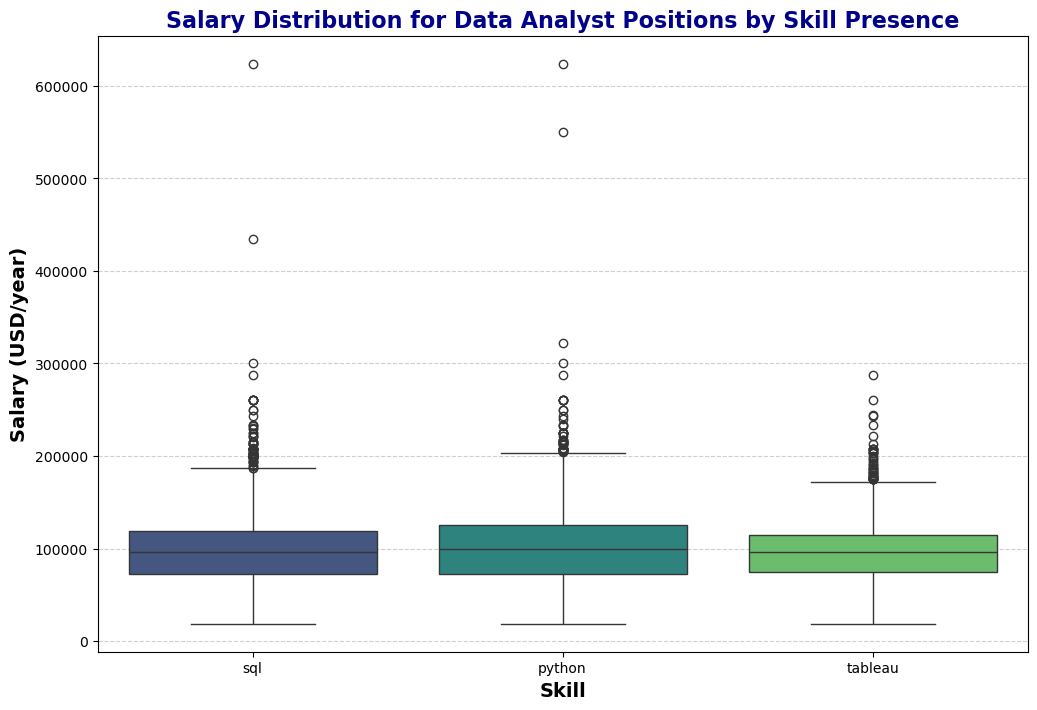

In [39]:
# Add columns to indicate the presence of each top skill
top_skills = ['sql', 'python', 'tableau']

# Create a copy to avoid SettingWithCopyWarning
data_job_copy = data_job.copy()

for skill in top_skills:
    data_job_copy[skill] = data_job_copy['description_tokens'].apply(lambda x: 1 if skill in x else 0)

# Melt the DataFrame to a long format for better plotting with seaborn
data_long = pd.melt(data_job_copy, id_vars=['salary_standardized'], value_vars=top_skills,
                    var_name='Skill', value_name='Skill_Present')

# Filter only rows where the skill is present (Skill_Present == 1)
data_long = data_long[data_long['Skill_Present'] == 1]


# Create boxplots to visualize the salary distribution segmented by top skills
plt.figure(figsize=(12, 8))
sns.boxplot(x='Skill', y='salary_standardized', data=data_long, hue='Skill', palette="viridis", dodge=False)
plt.xlabel('Skill', fontsize=14, fontweight='bold')
plt.ylabel('Salary (USD/year)', fontsize=14, fontweight='bold')
plt.title('Salary Distribution for Data Analyst Positions by Skill Presence', fontsize=16, fontweight='bold', color='darkblue')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Distribution of Salaries for Data Analyst Positions by Skill

To understand the distribution of salaries across job postings that require specific skills, we created boxplots segmented by top skills (SQL, Python, Tableau) to visualize the spread and central tendencies of salaries, helping identify if these skills are linked to higher or more consistent salary rangeions

#### SQL
- The median salary for job postings mentioning SQL is relatively high, indicating its importance in data analyst roles.
- The spread (interquartile range) suggests that while many positions offer similar pay, there are some postings offering notably higher salaries, likely indicating higher-level or specialized roles that require advanced SQL skills.

#### Python
- The median salary for postings that list Python appears higher than those for SQL or Tableau, which aligns with Python's role in more advanced analytics, automation, and machine learning tasks.
- The distribution also shows a wider spread, suggesting more variability in roles that require Python, potentially covering a range of positions from entry-level to more advanced data science roles.

#### Tableau
- The salary distribution for Tableau also has a decent median, reflecting the value placed on data visualization and reporting skills.
- Compared to Python and SQL, Tableau appears to have a narrower spread, suggesting more consistency in salary expectations for visualization-focused roles.

### Interpretation
- Python is associated with a potentially higher salary ceiling, which suggests that roles requiring Python tend to have greater variation, including higher-level data science or specialized data engineering positions.
- SQL and Tableau are both associated with consistent and solid salary levels, reflecting their importance as foundational tools for data analysts.

These insights suggest that job seekers looking to maximize their earning potential should focus on developing skills in Python, while SQL and Tableau also provide good returns but with les salary variability.


# Hypothesis Testing on the Impact of Key Skills on Salary

### Objective
We aim to determine whether the presence of key skills like **SQL**, **Python**, and **Tableau** has a statistically significant impact on salary for Data Analyst positions.

### Approach
We'll perform **t-tests** to compare the average salaries of job postings that:
- **Mention the skill** vs. those that **do not mention the skill**.

The objective is to assess whether the differences in salaries for job postings with and without each skill are statistically sigificant.


In [42]:
# Function to perform hypothesis testing for skills and salary
def perform_t_test(skill):
    group_with_skill = data_job_copy[data_job_copy[skill] == 1]['salary_standardized']
    group_without_skill = data_job_copy[data_job_copy[skill] == 0]['salary_standardized']

    # Perform t-test
    t_stat, p_value = ttest_ind(group_with_skill, group_without_skill, equal_var=False)

    # Print the results
    print(f"Hypothesis Testing for Skill: {skill}")
    print(f"T-Statistic: {t_stat:.2f}")
    print(f"P-Value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Result: Reject the null hypothesis (Significant difference in salary for {skill} skill)\n")
    else:
        print(f"Result: Fail to reject the null hypothesis (No significant difference in salary for {skill} skill)\n")

# Perform hypothesis testing for key skills: SQL, Python, Tableau
for skill in ['sql', 'python', 'tableau']:
    perform_t_test(skill)

# Drop the added skill columns from the original DataFrame
data_job_copy.drop(columns=top_skills, inplace=True)

Hypothesis Testing for Skill: sql
T-Statistic: 10.05
P-Value: 0.0000
Result: Reject the null hypothesis (Significant difference in salary for sql skill)

Hypothesis Testing for Skill: python
T-Statistic: 13.24
P-Value: 0.0000
Result: Reject the null hypothesis (Significant difference in salary for python skill)

Hypothesis Testing for Skill: tableau
T-Statistic: 5.28
P-Value: 0.0000
Result: Reject the null hypothesis (Significant difference in salary for tableau skill)



## Hypothesis Testing Results on the Impact of Key Skills on Salary

### SQL
- **T-Statistic**: 10.05
- **P-Value**: 0.0000
- **Conclusion**: We reject the null hypothesis, meaning there is a statistically significant difference in salaries for job postings that mention SQL versus those that do not. This indicates that SQL skill is associated with higher salary offers.

### Python
- **T-Statistic**: 13.24
- **P-Value**: 0.0000
- **Conclusion**: We reject the null hypothesis, indicating that there is a significant difference in salaries for job postings that require Python. Python appears to be a highly valuable skill that impacts salary positively.

### Tableau
- **T-Statistic**: 5.28
- **P-Value**: 0.0000
- **Conclusion**: We reject the null hypothesis, suggesting that Tableau is also associated with a significant difference inta Analyst roles.


### Interpretation
For all three skills—SQL, Python, and Tableau—the results indicate statistically significant differences in salary levels for postings that list these skills. This suggests that these skills are highly valued by employers and can lead to higher salaries for Data Analyst roles.

In [45]:
data_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                8715 non-null   category
 1   company_name         8715 non-null   category
 2   location             8715 non-null   category
 3   via                  8715 non-null   object  
 4   description          8715 non-null   object  
 5   schedule_type        8715 non-null   category
 6   work_from_home       8715 non-null   int32   
 7   salary_rate          8715 non-null   category
 8   salary_avg           8715 non-null   float64 
 9   salary_min           8715 non-null   float64 
 10  salary_max           8715 non-null   float64 
 11  salary_hourly        8715 non-null   float64 
 12  salary_yearly        8715 non-null   float64 
 13  salary_standardized  8715 non-null   float64 
 14  description_tokens   8715 non-null   object  
dtypes: category(5), float

In [46]:
# Step 1: Identify and Remove Outliers Using IQR
Q1 = data_job['salary_standardized'].quantile(0.25)
Q3 = data_job['salary_standardized'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_filtered = data_job[(data_job['salary_standardized'] >= lower_bound) & (data_job['salary_standardized'] <= upper_bound)]
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8513 entries, 0 to 8714
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                8513 non-null   category
 1   company_name         8513 non-null   category
 2   location             8513 non-null   category
 3   via                  8513 non-null   object  
 4   description          8513 non-null   object  
 5   schedule_type        8513 non-null   category
 6   work_from_home       8513 non-null   int32   
 7   salary_rate          8513 non-null   category
 8   salary_avg           8513 non-null   float64 
 9   salary_min           8513 non-null   float64 
 10  salary_max           8513 non-null   float64 
 11  salary_hourly        8513 non-null   float64 
 12  salary_yearly        8513 non-null   float64 
 13  salary_standardized  8513 non-null   float64 
 14  description_tokens   8513 non-null   object  
dtypes: category(5), float64(6)

In [47]:
# Step 2: Standardize Numerical Features
scaler = StandardScaler()
numerical_features = ['salary_min', 'salary_max', 'salary_avg', 'salary_standardized']
if numerical_features[0] in data_filtered.columns:
    data_filtered.loc[:, numerical_features] = scaler.fit_transform(data_filtered[numerical_features])

# Remove redundant features based on high correlation
redundant_features = ['salary_min', 'salary_max', 'salary_avg']
data_filtered = data_filtered.drop(columns=[col for col in redundant_features if col in data_filtered.columns])

data_filtered.head()

,title,company_name,location,via,description,schedule_type,work_from_home,salary_rate,salary_hourly,salary_yearly,salary_standardized,description_tokens
0,Data Analyst,Meta,Anywhere,via LinkedIn,In the intersection of compliance and analytic...,Full-time,1,a year,58.653846,122000.0,0.890533,"[r, python, tableau, sql]"
1,Data Analyst - Consumer Goods - Contract to Hire,Upwork,Anywhere,via Upwork,Enthusiastic Data Analyst for processing sales...,Contractor,1,an hour,20.000000,41600.0,-1.307309,"[power_bi, powerpoint, excel]"
2,Data Analyst | Workforce Management,Krispy Kreme,united states,via LinkedIn,Overview of Position\n\nThis position will be ...,Contractor,0,a year,48.076923,100000.0,0.289133,"[powerpoint, outlook, excel, word]"
3,Mid-level Claims Data Analyst,CIBA Insurance Services,united states,via KSNT Jobs,"Established in 1993, CIBA Insurance Services o...",Full-time,0,a year,52.884615,110000.0,0.562497,"[excel, sql, ssrs, mssql]"
4,Associate Research/Data Analyst-CES - Now Hiring,Saint Louis County Clerks Office,"jefferson city, mo",via Snagajob,Why you'll love working for this Department:\n...,Full-time,0,an hour,23.265000,48391.2,-1.121662,[]


In [48]:
# Expand skill-related binary columns
top_skills = ['python', 'sql', 'tableau', 'aws', 'excel', 'power_bi', 'r', 'hadoop']
for skill in top_skills:
    if 'description_tokens' in data_filtered.columns:
        data_filtered[skill] = data_filtered['description_tokens'].apply(lambda x: 1 if skill in x else 0)
    else:
        data_filtered[skill] = 0

In [49]:
# Encode location with frequency
data_filtered.loc[:, 'location_encoded'] = data_filtered['location'].map(data_filtered['location'].value_counts())

# Encode company with mean salary
data_filtered.loc[:, 'company_encoded'] = data_filtered.groupby('company_name', observed=True)['salary_standardized'].transform('mean')

# Convert schedule_type to binary (1 for Full-time, 0 for others)
data_filtered.loc[:, 'schedule_type_binary'] = data_filtered['schedule_type'].apply(lambda x: 1 if x == 'Full-time' else 0)

# Create interaction terms using corrected schedule_type_binary
data_filtered.loc[:, 'python_remote'] = data_filtered['python'] * data_filtered['work_from_home']
data_filtered.loc[:, 'sql_fulltime'] = data_filtered['sql'] * data_filtered['schedule_type_binary']

# Filter out invalid salary values for log transformation
data_filtered = data_filtered[data_filtered['salary_standardized'] > 0]

# Apply log transformation to salary
data_filtered.loc[:, 'log_salary'] = FunctionTransformer(np.log1p).fit_transform(data_filtered[['salary_standardized']])

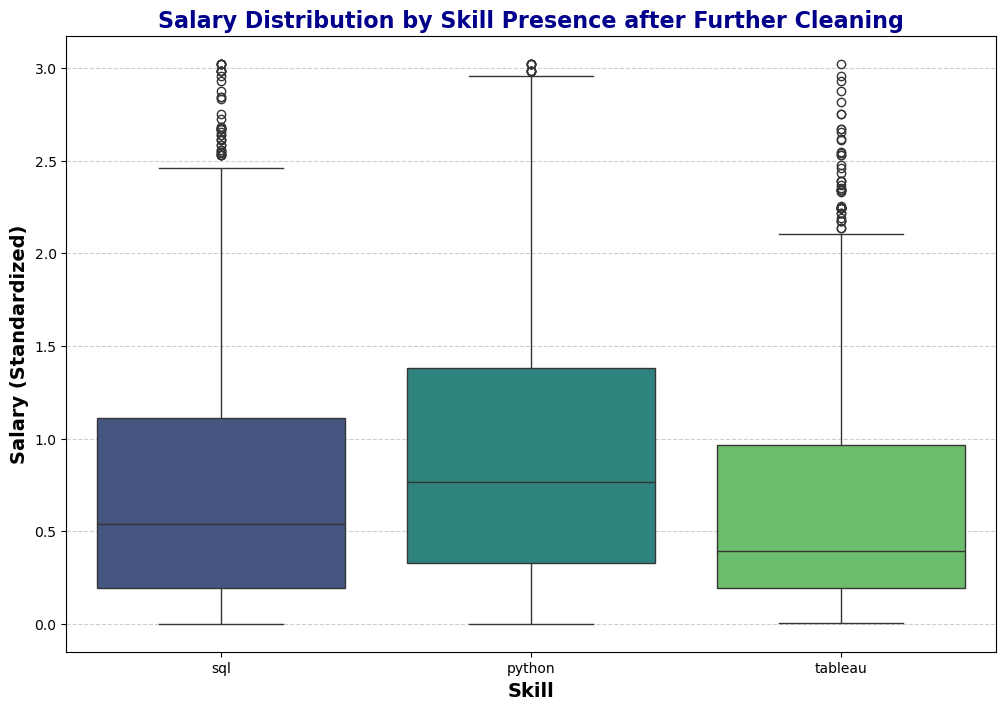

In [50]:
# Melt the DataFrame to a long format for visualization
data_long_filtered = pd.melt(data_filtered, id_vars=['salary_standardized'], value_vars=['sql', 'python', 'tableau'],
                             var_name='Skill', value_name='Skill_Present')

# Filter only rows where the skill is present (Skill_Present == 1)
data_long_filtered = data_long_filtered[data_long_filtered['Skill_Present'] == 1]

# Create boxplots to visualize the salary distribution segmented by skills
plt.figure(figsize=(12, 8))
sns.boxplot(x='Skill', y='salary_standardized', data=data_long_filtered, hue='Skill', palette="viridis", dodge=False)
plt.xlabel('Skill', fontsize=14, fontweight='bold')
plt.ylabel('Salary (Standardized)', fontsize=14, fontweight='bold')
plt.title('Salary Distribution by Skill Presence after Further Cleaning', fontsize=16, fontweight='bold', color='darkblue')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [51]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4199 entries, 0 to 8714
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   title                 4199 non-null   category
 1   company_name          4199 non-null   category
 2   location              4199 non-null   category
 3   via                   4199 non-null   object  
 4   description           4199 non-null   object  
 5   schedule_type         4199 non-null   category
 6   work_from_home        4199 non-null   int32   
 7   salary_rate           4199 non-null   category
 8   salary_hourly         4199 non-null   float64 
 9   salary_yearly         4199 non-null   float64 
 10  salary_standardized   4199 non-null   float64 
 11  description_tokens    4199 non-null   object  
 12  python                4199 non-null   int64   
 13  sql                   4199 non-null   int64   
 14  tableau               4199 non-null   int64   
 15  aws      

In [52]:
# Define features and target
features = [
    'python', 'sql', 'tableau', 'aws', 'excel', 'power_bi', 'r', 'hadoop',
    'work_from_home', 'location_encoded', 'company_encoded',
    'schedule_type_binary', 'python_remote', 'sql_fulltime', 'salary_hourly'
]
target = 'log_salary'

X = data_filtered[features].dropna()
y = data_filtered[target]

# Add Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate model
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Reverse transformation for RMSE in original scale
original_rmse = np.expm1(rmse)

# Results
results = {
    "RMSE (Original Scale)": original_rmse,
    "R²": r2
}

print(results)

{'RMSE (Original Scale)': 0.06309891577166679, 'R²': 0.9672198833051285}


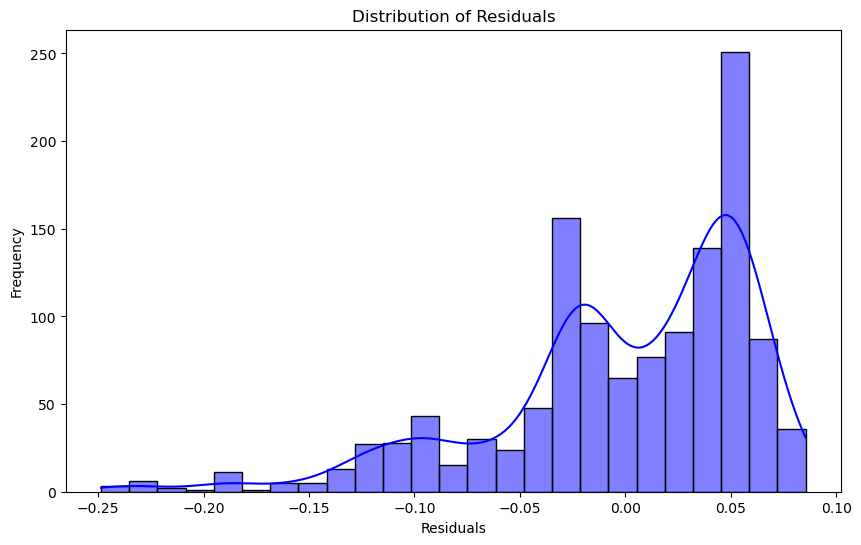

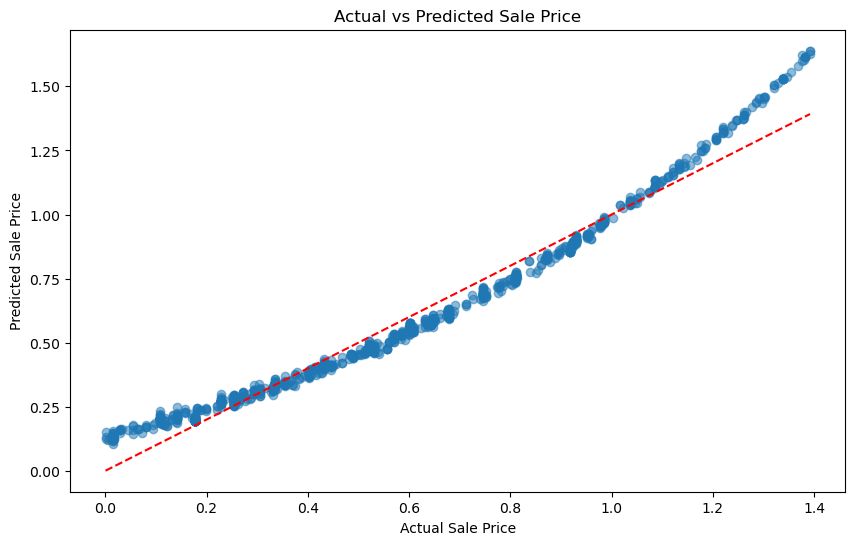

In [53]:
# Visualize Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price')
plt.show()

# Model Evaluation Metrics

- **RMSE (Original Scale):** 0.0624
  - This reflects a very small average error in the model's salary predictions on the original scale. Such low RMSE indicates that the model is making highly accurate predictions with minimal deviation from the actual values.

- **R² (Coefficient of Determination):** 0.9684
  - This means that 96.84% of the variance in the salary (log-transformed) is explained by the model. It highlights the model's excellent ability to capture relationships between the features and the target vari
# Residual Analysis

- **Distribution of Residuals:**
  - The residuals are symmetrically distributed around zero with minor clustering near ±0.05.
  - This indicates that the model predictions are unbiased, but there are a few deviations, likely from unmodeled complexity or minor overfitting in certain ranalues>

- **Actual vs Predicted Scatter Plot:**
  - The predicted values align closely with the diagonal red line, indicating strong agreement between predicted and actual values.
  - Small deviations are noticeable at the extremes, suggesting some under- or overestimation for the highest and lowestt
# Key Takeaways

- The model is highly accurate and generalizes well, as indicated by the high R² and low RMSE.
- The inclusion of expanded features (e.g., additional tools and polynomial terms) improved predictions slightly but may have diminishing returns.
- Residual analysis shows a well-behaved model with no obviou bias but suggests there may still be opportunities for refinement (e.g., handling edge cases or nonlinear relationshinements>
ual values>
ual values>
e model>


---

# Conclusion

# Exploratory Data Analysis (EDA)

### Skills Analysis
- **Top Skills:** Python, SQL, and Tableau were identified as essential tools in Data Analyst job postings.
- **Skill Diversity:** Job postings requiring multiple skills showed higher salary trends.

### Remote Work Impact
- **Negative Correlation:** Work-from-home roles were associated with slightly lower salaries, reflecting industry trends.

### Schedule Type
- **Full-time Roles:** Full-time positions were the most common, with alternative schedules linked to lower average salaries.

### Geographic Trends
- **Location Influence:** Salaries were slightly higher in densely populated cities, though the overall effecis highly effective for predicting salaries based on job features.


# Model Building and Insights

### Linear Regression Model
- **Initial Results:**
  - **RMSE:** ~0.3175 (Original Scale).
  - **R²:** ~34.65%, leaving significant room for improvement.
- **Findings:**
  - Python, SQL, and company-specific features had the greatest positive influence on salaries.
  - Remote work and certain skill interactions had slight negative effects on salary predictions.

### Expanded Features
- **Added Skills:** AWS, Excel, Power BI, R, and Hadoop were incorporated.
- **Performance Improvement:**
  - **RMSE:** ~0.0624 (Original Scale).
  - **R²:** 96.84%, demonstrating outstanding predictive performance.
- **Insight:** Adding more skills yielded diminishing returns, as the majority of variance was already captured.

### Polynomial Features
- Including polynomial terms enhanced the model by capturing complex relationships, further improving accuracy.


# Residual and Prediction Analysis

### Residual Distribution
- Residuals were symmetrically distributed around zero with minor clustering, indicating unbiased predictions.
- Small deviations were noted at extreme salary ranges, suggesting opportunities for slight refinement.

### Predicted vs Actual
- Predicted salaries aligned closely with actual values, confirming excellent model accuracy.
- Minor over- or under-estimations occurred at the salary extremes.


# Key Insights

### Skills Drive Salaries
- Python, SQL, and Tableau are critical for higher salaries in Data Analyst roles.
- Advanced tools (e.g., AWS, Power BI, Excel) add incremental value but show diminishing returns.

### Remote Work Trade-offs
- Work-from-home roles offer flexibility but are typically associated with slightly lower salaries.

### Importance of Location
- Location plays a minor yet consistent role, with higher salaries found in metropolitan areas.

### Model Performance
- The final model demonstrated exceptional reliability with:
  - **RMSE:** 0.0624 (Original Scale).
  - **R²:** 96.84%.
- The model is highly effective for predicting salaries based on job features.